In [1]:
using Revise

In [2]:
using PyCall, PyPlot, JuMP
using ClimateMARGO

In [3]:
using ClimateMARGO.Diagnostics
using ClimateMARGO.Models

In [4]:
using Combinatorics

┌ Info: Precompiling Combinatorics [861a8166-3701-5b0c-9a16-15d98fcdc6aa]
└ @ Base loading.jl:1260


# Optimizating the Global Climate Action Policy Portfolio

In [5]:
model_og = ClimateModel(ClimateMARGO.IO.included_configurations["default"]);
max_deployment_og = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>1., "adapt"=>0.4)

Dict{String,Float64} with 4 entries:
  "geoeng"   => 1.0
  "mitigate" => 1.0
  "remove"   => 1.0
  "adapt"    => 0.4

In [6]:
controls = collect(keys(max_deployment_og));

In [7]:
control_permutations = combinations(controls) |> collect

15-element Array{Array{String,1},1}:
 ["geoeng"]
 ["mitigate"]
 ["remove"]
 ["adapt"]
 ["geoeng", "mitigate"]
 ["geoeng", "remove"]
 ["geoeng", "adapt"]
 ["mitigate", "remove"]
 ["mitigate", "adapt"]
 ["remove", "adapt"]
 ["geoeng", "mitigate", "remove"]
 ["geoeng", "mitigate", "adapt"]
 ["geoeng", "remove", "adapt"]
 ["mitigate", "remove", "adapt"]
 ["geoeng", "mitigate", "remove", "adapt"]

In [8]:
results = Dict()

for control_permutation in control_permutations
    model = ClimateModel(ClimateMARGO.IO.included_configurations["default"]);
    
    # Assert that some controls not be deployed
    max_deployment = copy(max_deployment_og)
    for control in controls
        if ~(control in control_permutation)
            max_deployment[control] = 0.
            # Override initial condition constraints
            if ~isnothing(getfield(model.economics, Symbol(string(control,"_init"))))
                setfield!(model.economics, Symbol(string(control,"_init")), 0.)
            end
        end
    end
    @time m = ClimateMARGO.Optimization.optimize_controls!(model, max_deployment = max_deployment, temp_goal=2.0);
    
    results[control_permutation] = Dict("model" => model, "NPV" => net_present_cost(model, M=true, R=true, G=true, A=true), "status" => raw_status(m))
    
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
 61.078068 seconds (122.02 M allocations: 6.821 GiB, 5.57% gc time)
Solve_Succeeded
  0.227573 seconds (233.64 k allocations: 10.372 MiB)
Infeasible_Problem_Detected
  0.349069 seconds (280.28 k allocations: 7.174 MiB)
Infeasible_Problem_Detected
  0.478632 seconds (334.96 k allocations: 8.133 MiB)
Solve_Succeeded
  0.077688 seconds (93.46 k allocations: 4.045 MiB)
Solve_Succeeded
  0.049992 seconds (69.93 k allocations: 3.627 MiB)
Solve_Succeeded
  0.073704 seconds (90.74 k allocations: 3.997 MiB)
Solve_Succeeded
  0.092594 seconds (106.51 k allocations: 4.294 MiB)
Solve_Succeeded
  0.089

In [9]:
min_value = Inf
for (index, value) in pairs(results)
    if (value["status"] == "Solve_Succeeded") & (value["NPV"] < min_value)
        min_value = value["NPV"]
    end
end

for (index, value) in pairs(results)
    if (value["status"] == "Solve_Succeeded")
        abs_value = Int64(round((value["NPV"])))
        rel_value = Int64(round((value["NPV"]/min_value - 1.)*100))
        print("$index, $abs_value, $rel_value%\n")
    else
        print("$index has no solution.\n")
    end
end


["geoeng", "mitigate", "remove"], 183, 8%
["remove"] has no solution.
["mitigate", "remove"], 264, 56%
["mitigate"], 355, 110%
["geoeng", "mitigate", "remove", "adapt"], 169, 0%
["geoeng", "adapt"], 301, 78%
["geoeng", "mitigate", "adapt"], 183, 8%
["mitigate", "remove", "adapt"], 241, 42%
["geoeng"], 408, 141%
["geoeng", "remove", "adapt"], 277, 64%
["mitigate", "adapt"], 283, 67%
["geoeng", "mitigate"], 202, 19%
["remove", "adapt"] has no solution.
["geoeng", "remove"], 367, 117%
["adapt"] has no solution.


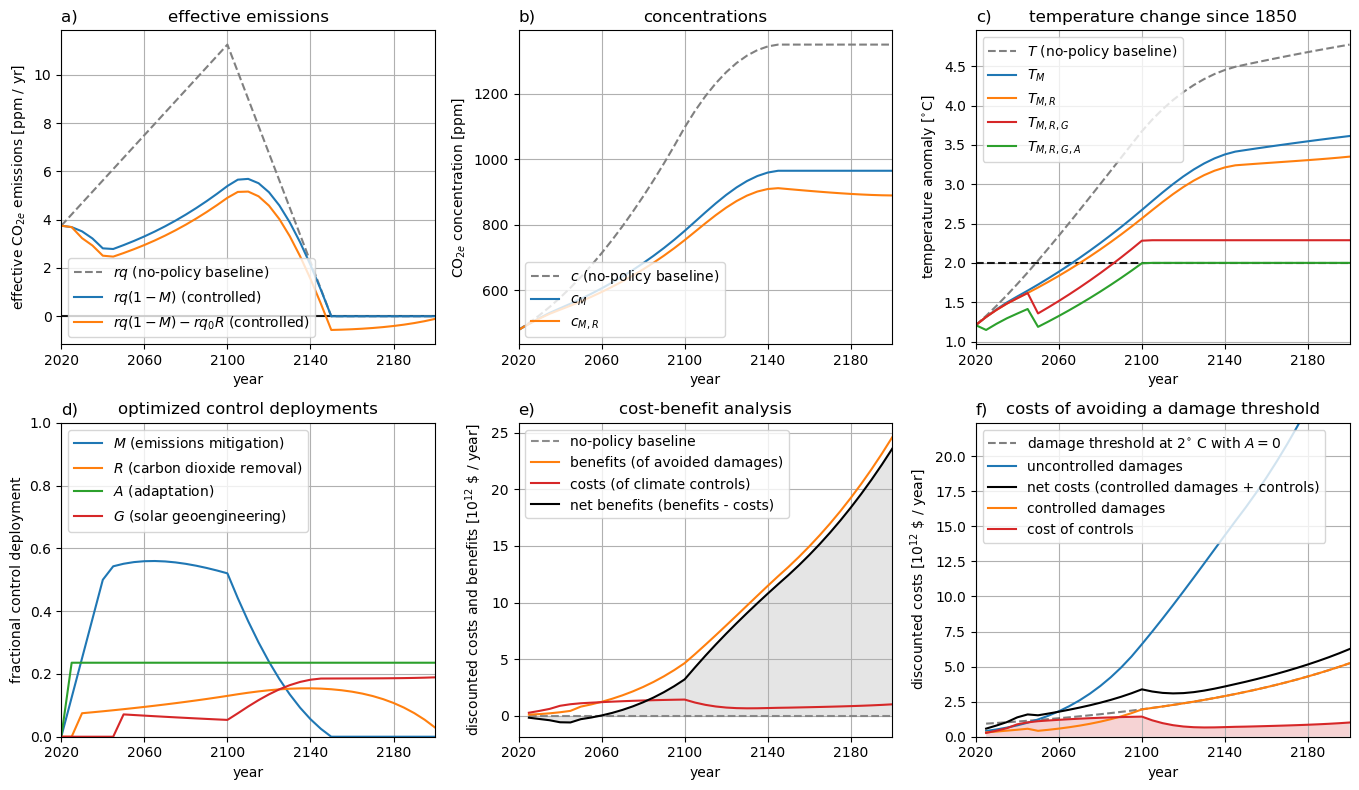

In [10]:
ClimateMARGO.Plotting.plot_state(results[["geoeng", "mitigate", "remove", "adapt"]]["model"])

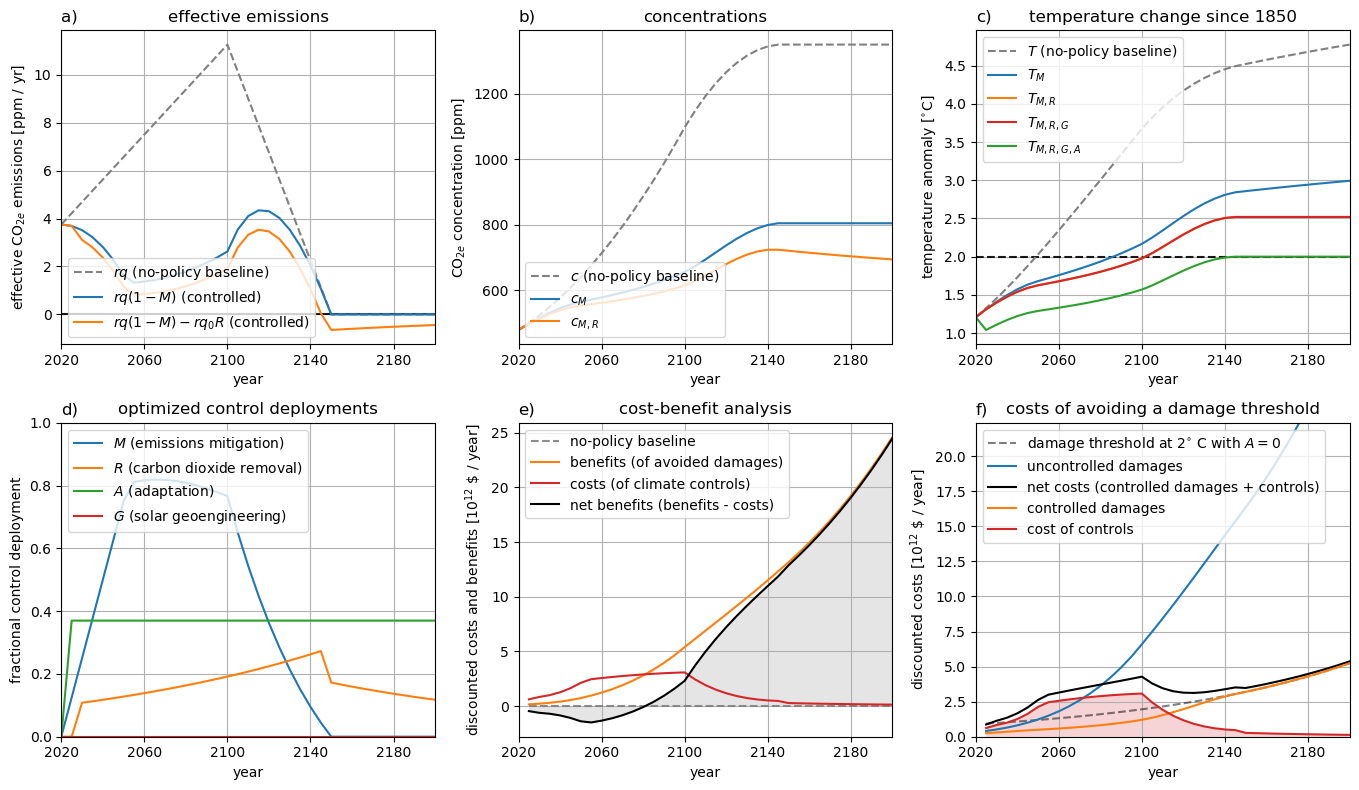

In [11]:
ClimateMARGO.Plotting.plot_state(results[["mitigate", "remove", "adapt"]]["model"])